# Examining Price Gradients for Control and Treatment Groups

By: Traci Lim

---


The basic idea of a Difference-in-Differences model is to have two groups: one that receives the 'treatment', and the other that does not. We are using data on the two groups, before and after the treatment occurs. DiD calculates the difference in outcomes before and after the treatment. Then, the difference between those two differences is the estimated effect of the treatment. We are implicitly assuming that the only thing that affects the gap between the treated and control groups is the policy we are studying. Everything that is time varying must be affecting both groups in the same way. We call this the parallel trends assumption, that means that the gap between the treated and control group would've remained the same if there is no treatment given to the treatment group.

We are interested in constructing a plot that shows that the parallel trends assumption holds with the selected treatment and control groups. The treatment group consists of flats that are within a 1km geodesic radius to the nearest DTL station from the year 2010 onwards. The control group consists of flats that are outside the 1km geodesic radius to the nearest DTL station from the year 2010 onwards. 

This notebook was done after the submission of the time-sensitive case study.

In [1]:
import glob
import os
import gc
import pandas as pd
import numpy as np
import geopy.distance
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

pd.set_option('display.max_columns', None)  
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def reduce_memory(df):
    for c in df.columns:
        if df[c].dtype=='int':
            if df[c].min()<0:
                if df[c].abs().max()<2**7:
                    df[c] = df[c].astype('int8')
                elif df[c].abs().max()<2**15:
                    df[c] = df[c].astype('int16')
                elif df[c].abs().max()<2**31:
                    df[c] = df[c].astype('int32')
                else:
                    continue
            else:
                if df[c].max()<2**8:
                    df[c] = df[c].astype('uint8')
                elif df[c].max()<2**16:
                    df[c] = df[c].astype('uint16')
                elif df[c].max()<2**32:
                    df[c] = df[c].astype('uint32')
                else:
                    continue
    return df

In [2]:
# Save it as csv file
#df_final.to_csv('data/df_final.csv')
df_final = pd.read_csv("data/df_final.csv")

In [3]:
df_final.head()

,Unnamed: 0,Unnamed: 0.1,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,full_address,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,lat_long,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,year,distance_to_city,year_month
0,4,4,216,New Generation,3 ROOM,73.0,1976,1,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,216 ANG MO KIO AVE 1,1.366197,103.841505,0.145364,0.954205,"('1.36619678831055', '103.841505011903')",10.0,1975.0,Y,N,N,N,N,1990,7.585695,1990-1
1,5,5,211,New Generation,3 ROOM,67.0,1977,1,46000.0,01 TO 03,ANG MO KIO AVE 3,ANG MO KIO,211 ANG MO KIO AVE 3,1.369197,103.841667,0.181780,0.867154,"('1.3691969656170402', '103.841666636086')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.908701,1990-1
2,6,6,202,New Generation,3 ROOM,67.0,1977,1,42000.0,07 TO 09,ANG MO KIO AVE 3,ANG MO KIO,202 ANG MO KIO AVE 3,1.368446,103.844516,0.000000,0.560273,"('1.3684464401094', '103.844516260527')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.925137,1990-1
3,7,7,235,New Generation,3 ROOM,67.0,1977,1,38000.0,10 TO 12,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1
4,8,8,235,New Generation,3 ROOM,67.0,1977,1,40000.0,04 TO 06,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1


---

### Investigating 2x Jump in median HDB resale prices in Central Area in 2015

In [14]:
df_final[(df_final['town']=='CENTRAL AREA') & (df_final['year']==2015)].describe()

,Unnamed: 0,Unnamed: 0.1,floor_area_sqm,lease_commence_date,month,resale_price,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,max_floor_lvl,year_completed,year,distance_to_city
count,7.560000e+02,7.560000e+02,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,552.000000,552.000000,756.0,756.000000
mean,2.737368e+06,2.737368e+06,89.396825,2000.962963,6.529101,7.383557e+05,1.284500,103.844410,0.303271,0.323260,46.934783,2006.963768,2015.0,3.418530
std,7.317848e+04,7.317848e+04,15.050509,14.649050,3.336406,2.277561e+05,0.012190,0.005494,0.163504,0.101366,9.172045,6.816665,0.0,0.263582
min,2.631519e+06,2.631519e+06,53.000000,1971.000000,1.000000,2.630000e+05,1.275532,103.838858,0.146162,0.040057,17.000000,1978.000000,2015.0,2.386741
25%,2.684556e+06,2.684556e+06,82.000000,1984.000000,4.000000,4.750000e+05,1.276622,103.841192,0.183818,0.248828,50.000000,2009.000000,2015.0,3.341694
50%,2.737594e+06,2.737594e+06,94.000000,2011.000000,7.000000,8.400000e+05,1.277799,103.841463,0.284877,0.357253,50.000000,2009.000000,2015.0,3.421435
75%,2.790632e+06,2.790632e+06,96.000000,2011.000000,9.000000,9.100000e+05,1.287623,103.842908,0.358324,0.406098,50.000000,2009.000000,2015.0,3.525504
max,2.843669e+06,2.843669e+06,137.000000,2011.000000,12.000000,1.088000e+06,1.309233,103.857480,0.839872,0.628989,50.000000,2009.000000,2015.0,4.028564


In [27]:
df_final[(df_final['town']=='CENTRAL AREA') & (df_final['year']==2015) & (df_final['resale_price']>=800000) & (df_final['street_name']>='CANTONMENT RD')].count()

Unnamed: 0                     472
Unnamed: 0.1                   472
block                          472
flat_model                     472
flat_type                      472
floor_area_sqm                 472
lease_commence_date            472
month                          472
resale_price                   472
storey_range                   472
street_name                    472
town                           472
full_address                   472
LATITUDE                       472
LONGITUDE                      472
distance_to_nearest_sch        472
distance_to_nearest_station    472
lat_long                       472
max_floor_lvl                  472
year_completed                 472
residential                    472
market_hawker                  472
miscellaneous                  472
multistorey_carpark            472
precinct_pavilion              472
year                           472
distance_to_city               472
year_month                     472
dtype: int64

In [26]:
df_final[(df_final['town']=='CENTRAL AREA') & (df_final['year']==2015) ].count()

Unnamed: 0                     756
Unnamed: 0.1                   756
block                          756
flat_model                     756
flat_type                      756
floor_area_sqm                 756
lease_commence_date            756
month                          756
resale_price                   756
storey_range                   756
street_name                    756
town                           756
full_address                   756
LATITUDE                       756
LONGITUDE                      756
distance_to_nearest_sch        756
distance_to_nearest_station    756
lat_long                       756
max_floor_lvl                  552
year_completed                 552
residential                    552
market_hawker                  552
miscellaneous                  552
multistorey_carpark            552
precinct_pavilion              552
year                           756
distance_to_city               756
year_month                     756
dtype: int64

### Filtering out Downtown Line stations

In [3]:
# Save/load latlong_df
#latlong_df.to_pickle('data/latlong_df.pkl')    
latlong_df = pd.read_pickle('data/latlong_df.pkl') 

In [4]:
# shapefile to csv converter; 
# Thanks to https://gist.github.com/aerispaha/f098916ac041c286ae92d037ba5c37ba
def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """
    import shapefile

    myshp = open(shp_path, "rb")
    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

In [5]:
mrt_latlong_df = read_shapefile("data/MRTLRTStnPtt.shp")

In [6]:
station_address_list = mrt_latlong_df["STN_NAME"].unique().tolist()
len(station_address_list)

164

In [7]:
%%time
import requests

station_search_results = []
querystring = {}

for x in station_address_list:
    url = "https://developers.onemap.sg/commonapi/search"
    

    querystring.update({"searchVal":x,"returnGeom":"Y","getAddrDetails":"Y","pageNum":"1"})
    #print (querystring['searchVal'])
    
    payload = "------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"email\"\r\n\r\nfourtyeightfourty@gmail.com\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW\r\nContent-Disposition: form-data; name=\"password\"\r\n\r\nPlatinum123\r\n------WebKitFormBoundary7MA4YWxkTrZu0gW--"

    headers = {
    'content-type': "multipart/form-data; boundary=----WebKitFormBoundary7MA4YWxkTrZu0gW",
    'Cache-Control': "no-cache",
    'Postman-Token': "c228e0a0-f5ab-429e-9cc4-6e8925bb70e8"
    }
    response = requests.request("GET", url, data=payload, headers=headers, params=querystring)
    

    station_search_results.append(response.json())

#print(response.text)
print('Search Done.')

Search Done.
Wall time: 12.8 s


In [8]:
station_latlong_df = pd.DataFrame()
for entry in range(len(station_search_results)):
    temp_df = pd.DataFrame.from_dict(station_search_results[entry]['results'])
    station_latlong_df = station_latlong_df.append(temp_df)

In [9]:
station_latlong_df.head()

,ADDRESS,BLK_NO,BUILDING,LATITUDE,LONGITUDE,LONGTITUDE,POSTAL,ROAD_NAME,SEARCHVAL,X,Y
0,EUNOS MRT STATION EXIT A SINGAPORE,,EUNOS MRT STATION EXIT A,1.31951727513527,103.902894137829,103.902894137829,NIL,NIL,EUNOS MRT STATION EXIT A,35743.077598623,33531.1416259985
1,EUNOS MRT STATION EXIT B SINGAPORE,,EUNOS MRT STATION EXIT B,1.31956254560617,103.90258207739,103.90258207739,NIL,NIL,EUNOS MRT STATION EXIT B,35708.3481746418,33536.1464371067
2,EUNOS MRT STATION EXIT C SINGAPORE,,EUNOS MRT STATION EXIT C,1.31960866729867,103.903178612002,103.903178612002,NIL,NIL,EUNOS MRT STATION EXIT C,35774.7365172636,33541.2481965665
3,30 EUNOS CRESCENT EUNOS MRT STATION SINGAPORE ...,30,EUNOS MRT STATION (EW7),1.31978354779207,103.903225812967,103.903225812967,409423,EUNOS CRESCENT,EUNOS MRT STATION (EW7),35779.9889810141,33560.5857454669
4,30 EUNOS CRESCENT DBS Eunos MRT Station SINGAP...,30,DBS Eunos MRT Station,1.31972715746684,103.903100260592,103.903100260592,409423,EUNOS CRESCENT,DBS Eunos MRT Station,35766.0164019587,33554.3499959968


In [10]:
downtown_station_latlong_df = station_latlong_df[station_latlong_df['ADDRESS'].str.contains("BUKIT PANJANG MRT|CASHEW MRT|HILLVIEW MRT|BEAUTY WORLD MRT|KING ALBERT|SIXTH AVENUE|TAN KAH KEE|BOTANIC GARDENS|\
                                                              STEVENS MRT|NEWTON MRT|LITTLE INDIA|ROCHOR|BUGIS|PROMENADE|BAYFRONT|DOWNTOWN|TELOK AYER|CHINATOWN|FORT CANNING|\
                                                              BENCOOLEN|JALAN BESAR|BENDEMEER|GEYLANG BAHRU|MATTAR|MACPHERSON|UBI|KAKI BUKIT|BEDOK NORTH|BEDOK RESERVOIR|\
                                                              TAMPINES WEST|TAMPINES|TAPINES EAST|UPPER CHANGI MRT|EXPO|DT")]

In [11]:
# Concatenate latitude and longitude columns into one column
downtown_station_latlong_df["lat_long"] = downtown_station_latlong_df["LATITUDE"] +' '+ downtown_station_latlong_df["LONGITUDE"]

# convert lat_long column to tuples
downtown_station_latlong_df["lat_long"] = downtown_station_latlong_df["lat_long"].apply(lambda x: tuple(x.split(' ')))

C:\Users\longwind48\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\longwind48\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
downtown_station_latlong_df

,ADDRESS,BLK_NO,BUILDING,LATITUDE,LONGITUDE,LONGTITUDE,POSTAL,ROAD_NAME,SEARCHVAL,X,Y,lat_long
0,TAMPINES MRT STATION EXIT E SINGAPORE,,TAMPINES MRT STATION EXIT E,1.35560210584207,103.94290544632,103.94290544632,NIL,NIL,TAMPINES MRT STATION EXIT E,40195.7703244854,37521.3851139769,"(1.35560210584207, 103.94290544632)"
1,TAMPINES MRT STATION EXIT A SINGAPORE,,TAMPINES MRT STATION EXIT A,1.35376401277765,103.944766312114,103.944766312114,NIL,NIL,TAMPINES MRT STATION EXIT A,40402.8731008144,37318.14722622,"(1.35376401277765, 103.944766312114)"
2,TAMPINES MRT STATION EXIT B SINGAPORE,,TAMPINES MRT STATION EXIT B,1.3535390815171,103.945089563391,103.945089563391,NIL,NIL,TAMPINES MRT STATION EXIT B,40438.8485063454,37293.2770833801,"(1.3535390815171, 103.945089563391)"
3,TAMPINES MRT STATION EXIT G SINGAPORE,,TAMPINES MRT STATION EXIT G,1.35452222167758,103.94266735136,103.94266735136,NIL,NIL,TAMPINES MRT STATION EXIT G,40169.2784230765,37401.9756178446,"(1.35452222167758, 103.94266735136)"
4,TAMPINES MRT STATION EXIT C SINGAPORE,,TAMPINES MRT STATION EXIT C,1.35339831285365,103.944903957552,103.944903957552,NIL,NIL,TAMPINES MRT STATION EXIT C,40418.1933618449,37277.7106225695,"(1.35339831285365, 103.944903957552)"
5,TAMPINES MRT STATION EXIT D SINGAPORE,,TAMPINES MRT STATION EXIT D,1.35510082756571,103.943394431323,103.943394431323,NIL,NIL,TAMPINES MRT STATION EXIT D,40250.1913722418,37465.9586848728,"(1.35510082756571, 103.943394431323)"
6,TAMPINES MRT STATION EXIT F SINGAPORE,,TAMPINES MRT STATION EXIT F,1.3540338687466,103.942694773846,103.942694773846,NIL,NIL,TAMPINES MRT STATION EXIT F,40172.3326745098,37347.9760820307,"(1.3540338687466, 103.942694773846)"
7,15 TAMPINES CENTRAL 1 TAMPINES MRT STATION SIN...,15,TAMPINES MRT STATION (DT32),1.35515041120475,103.943009883131,103.943009883131,529544,TAMPINES CENTRAL 1,TAMPINES MRT STATION (DT32),40207.3952279193,37471.4394600242,"(1.35515041120475, 103.943009883131)"
8,20 TAMPINES CENTRAL 1 TAMPINES MRT STATION SIN...,20,TAMPINES MRT STATION (EW2),1.35330153265954,103.945144689278,103.945144689278,529538,TAMPINES CENTRAL 1,TAMPINES MRT STATION (EW2),40444.9846136123,37267.0103757698,"(1.35330153265954, 103.945144689278)"
9,20 TAMPINES CENTRAL 1 UOB Tampines MRT Station...,20,UOB Tampines MRT Station,1.35364658483911,103.944838289765,103.944838289765,529538,TAMPINES CENTRAL 1,UOB Tampines MRT Station,40410.8840069929,37305.1629876383,"(1.35364658483911, 103.944838289765)"


---

### Calculating the geodesic distance from each flat to the nearest downtown line station

In [13]:
downtown_station_latlong_df.reset_index()
# convert the lat_long column in station_latlong_df to a list
downtown_station_latlong_list = list(downtown_station_latlong_df.T.iloc[-1,:])

In [14]:
%%time
downtown_station_distance_df = pd.DataFrame(latlong_df["lat_long"])

for x in downtown_station_latlong_list:
    downtown_station_distance_df[x]=latlong_df['lat_long'].apply(lambda y: geopy.distance.vincenty(y, x).km)

Wall time: 34.6 s


In [15]:
downtown_station_distance_df.shape

(11784, 107)

In [16]:
# get the distance from each address to the nearest station
downtown_station_distance_df['distance_to_nearest_downtown_station'] = downtown_station_distance_df.iloc[:,1:].apply(lambda x: min(x), axis=1)

In [17]:
downtown_station_distance_df = downtown_station_distance_df.iloc[:,[0,-1]]
downtown_station_distance_df.head(1)

,lat_long,distance_to_nearest_downtown_station
0,"(1.36619678831055, 103.841505011903)",5.649468


In [18]:
# Merge our results into the main hdb address dataframe: latlong_df
latlong_df = pd.merge(latlong_df, downtown_station_distance_df, on='lat_long', how='left')

In [19]:
latlong_df = latlong_df[['full_address', 'distance_to_nearest_downtown_station']]

In [20]:
latlong_df_nodup = latlong_df.drop_duplicates('full_address')

In [21]:
latlong_df_nodup['full_address'] = latlong_df_nodup['full_address'].str.replace('AVENUE', 'AVE') \
                                    .str.replace('CRESCENT', 'CRES') \
                                    .str.replace('ROAD', 'RD') \
                                    .str.replace('STREET', 'ST') \
                                    .str.replace('CENTRAL', 'CTRL') \
                                    .str.replace('HEIGHTS', 'HTS') \
                                    .str.replace('TERRACE', 'TER') \
                                    .str.replace('JALAN', 'JLN') \
                                    .str.replace('DRIVE', 'DR') \
                                    .str.replace('PLACE', 'PL') \
                                    .str.replace('CLOSE', 'CL') \
                                    .str.replace('PARK', 'PK') \
                                    .str.replace('GARDENS', 'GDNS') \
                                    .str.replace('NORTH', 'NTH') \
                                    .str.replace('SOUTH', 'STH') \
                                    .str.replace('BUKIT', 'BT') \
                                    .str.replace('UPPER', 'UPP}') \
                                    .str.replace('COMMONWEALTH', "C'WEALTH") \

C:\Users\longwind48\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_final = pd.merge(df_final, latlong_df_nodup, on='full_address', how='left')

In [23]:
df_final.head()

,Unnamed: 0,Unnamed: 0.1,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,full_address,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,lat_long,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,year,distance_to_city,year_month,distance_to_nearest_downtown_station
0,4,4,216,New Generation,3 ROOM,73.0,1976,1,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,216 ANG MO KIO AVE 1,1.366197,103.841505,0.145364,0.954205,"('1.36619678831055', '103.841505011903')",10.0,1975.0,Y,N,N,N,N,1990,7.585695,1990-1,5.649468
1,5,5,211,New Generation,3 ROOM,67.0,1977,1,46000.0,01 TO 03,ANG MO KIO AVE 3,ANG MO KIO,211 ANG MO KIO AVE 3,1.369197,103.841667,0.181780,0.867154,"('1.3691969656170402', '103.841666636086')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.908701,1990-1,5.945211
2,6,6,202,New Generation,3 ROOM,67.0,1977,1,42000.0,07 TO 09,ANG MO KIO AVE 3,ANG MO KIO,202 ANG MO KIO AVE 3,1.368446,103.844516,0.000000,0.560273,"('1.3684464401094', '103.844516260527')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.925137,1990-1,5.996856
3,7,7,235,New Generation,3 ROOM,67.0,1977,1,38000.0,10 TO 12,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1,5.446123
4,8,8,235,New Generation,3 ROOM,67.0,1977,1,40000.0,04 TO 06,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1,5.446123


In [24]:
df_final1 = df_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [25]:
df_final1['price_per_sqm'] =  df_final1['resale_price'] / df_final1['floor_area_sqm']

In [27]:
df_final1.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,full_address,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,lat_long,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,year,distance_to_city,year_month,distance_to_nearest_downtown_station,price_per_sqm
0,216,New Generation,3 ROOM,73.0,1976,1,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,216 ANG MO KIO AVE 1,1.366197,103.841505,0.145364,0.954205,"('1.36619678831055', '103.841505011903')",10.0,1975.0,Y,N,N,N,N,1990,7.585695,1990-1,5.649468,646.575342
1,211,New Generation,3 ROOM,67.0,1977,1,46000.0,01 TO 03,ANG MO KIO AVE 3,ANG MO KIO,211 ANG MO KIO AVE 3,1.369197,103.841667,0.181780,0.867154,"('1.3691969656170402', '103.841666636086')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.908701,1990-1,5.945211,686.567164
2,202,New Generation,3 ROOM,67.0,1977,1,42000.0,07 TO 09,ANG MO KIO AVE 3,ANG MO KIO,202 ANG MO KIO AVE 3,1.368446,103.844516,0.000000,0.560273,"('1.3684464401094', '103.844516260527')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,7.925137,1990-1,5.996856,626.865672
3,235,New Generation,3 ROOM,67.0,1977,1,38000.0,10 TO 12,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1,5.446123,567.164179
4,235,New Generation,3 ROOM,67.0,1977,1,40000.0,04 TO 06,ANG MO KIO AVE 3,ANG MO KIO,235 ANG MO KIO AVE 3,1.366824,103.836491,0.203720,1.471209,"('1.36682360872345', '103.83649123351')",12.0,1976.0,Y,N,Y,N,N,1990,7.509993,1990-1,5.446123,597.014925


### Observing only flats sold in 2010 to 2018

In [29]:
df_final1_2010_to_2018 = df_final1[df_final1['year']>=2010]

In [30]:
df_final1_2010_to_2018.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,full_address,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,lat_long,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,year,distance_to_city,year_month,distance_to_nearest_downtown_station,price_per_sqm
1372061,208,New Generation,3 ROOM,73.0,1976,1,304000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,208 ANG MO KIO AVE 1,1.365445,103.842715,0.218311,0.869874,"('1.36544495225354', '103.842715047475')",12.0,1975.0,Y,N,Y,N,N,2010,7.546926,2010-1,5.649688,4164.383562
1372062,220,Adjoined flat,5 ROOM,134.0,1977,1,455000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO,220 ANG MO KIO AVE 1,1.365588,103.840519,0.265601,1.081369,"('1.3655883359306598', '103.84051888325399')",13.0,1976.0,Y,N,Y,N,N,2010,7.489863,2010-1,5.535630,3395.522388
1372063,319,New Generation,4 ROOM,98.0,1977,1,410000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,319 ANG MO KIO AVE 1,1.365098,103.847381,0.401682,0.531614,"('1.36509785283535', '103.847380723566')",12.0,1976.0,Y,N,Y,N,N,2010,7.688310,2010-1,5.517100,4183.673469
1372064,319,New Generation,3 ROOM,73.0,1977,1,307000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,319 ANG MO KIO AVE 1,1.365098,103.847381,0.401682,0.531614,"('1.36509785283535', '103.847380723566')",12.0,1976.0,Y,N,Y,N,N,2010,7.688310,2010-1,5.517100,4205.479452
1372065,306,Standard,5 ROOM,123.0,1977,1,505000.0,01 TO 03,ANG MO KIO AVE 1,ANG MO KIO,306 ANG MO KIO AVE 1,1.365726,103.845751,0.270041,0.581066,"('1.36572552222848', '103.845750564626')",16.0,1976.0,Y,N,N,N,N,2010,7.687628,2010-1,5.667862,4105.691057


In [31]:
df_final1_2010_to_2018['num_months_from_jan_2010'] = df_final1_2010_to_2018['month'] + (df_final1_2010_to_2018['year'] - 2010)*12

C:\Users\longwind48\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
within_1km_dt_station_df = df_final1_2010_to_2018[df_final1_2010_to_2018['distance_to_nearest_downtown_station']<=1]

not_within_1km_dt_station_df = df_final1_2010_to_2018[df_final1_2010_to_2018['distance_to_nearest_downtown_station']>1]

---


In [35]:
df_avg_price_per_sqm_within_1km = within_1km_dt_station_df.groupby('num_months_from_jan_2010')['price_per_sqm'].mean().reset_index()
df_avg_price_per_sqm_not_within_1km = not_within_1km_dt_station_df.groupby('num_months_from_jan_2010')['price_per_sqm'].mean().reset_index()

In [36]:
df_avg_price_per_sqm_within_1km = df_avg_price_per_sqm_within_1km.rename(index=str, columns={"price_per_sqm": "avg_price_per_sqm"})
df_avg_price_per_sqm_not_within_1km = df_avg_price_per_sqm_not_within_1km.rename(index=str, columns={"price_per_sqm": "avg_price_per_sqm"})

In [37]:
within_1km_dt_station_df = pd.merge(within_1km_dt_station_df, df_avg_price_per_sqm_within_1km, on='num_months_from_jan_2010', how='left')
not_within_1km_dt_station_df = pd.merge(not_within_1km_dt_station_df, df_avg_price_per_sqm_not_within_1km, on='num_months_from_jan_2010', how='left')

In [78]:
within_1km_dt_station_df['log_avg_price_per_sqm'] = np.log(within_1km_dt_station_df['avg_price_per_sqm'])
not_within_1km_dt_station_df['log_avg_price_per_sqm'] = np.log(not_within_1km_dt_station_df['avg_price_per_sqm'])

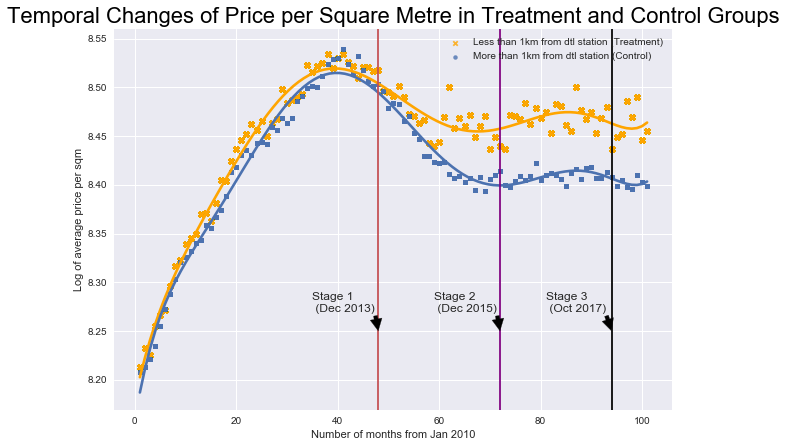

In [96]:
# Fit a higher-order polynomial regression and truncate the model prediction:
plt.subplots(figsize=(10,7))
ax = sns.regplot(x="num_months_from_jan_2010", y="log_avg_price_per_sqm", data=within_1km_dt_station_df,
                  scatter_kws={"s": 20}, color='orange',
                 order=7, ci=None, truncate=True, marker="x", label="Less than 1km from dtl station (Treatment)")

sns.regplot(x="num_months_from_jan_2010", y="log_avg_price_per_sqm", data=not_within_1km_dt_station_df,
                  scatter_kws={"s": 20},
                 order=7, ci=None, truncate=True, label="More than 1km from dtl station (Control)")
plt.axvline(48, color='r')
plt.axvline(72, color='purple')
plt.axvline(94, color='black')
plt.annotate('Stage 1\n (Dec 2013)', xy=(48, 8.25), xytext=(35, 8.27), arrowprops=dict(facecolor='black', shrink=0.01))
plt.annotate('Stage 2\n (Dec 2015)', xy=(72, 8.25), xytext=(59, 8.27), arrowprops=dict(facecolor='black', shrink=0.01))
plt.annotate('Stage 3\n (Oct 2017)', xy=(94, 8.25), xytext=(81, 8.27), arrowprops=dict(facecolor='black', shrink=0.01))
plt.legend()
plt.title("Temporal Changes of Price per Square Metre in Treatment and Control Groups", loc='center', fontsize=22, fontweight=1, color='black')
plt.ylabel("Log of average price per sqm")
plt.xlabel("Number of months from Jan 2010")
ax.legend()
#ax.set(xlabel='Number of months from Jan 2010', ylabel='Average price per square metre')

We plot log-average-price-per-sqm with respect to the sale time, which is indicated by the number of months starting from the first sample date of Jan 2010. The curves show the price gradient for houses in the control and treatment groups, fitted by a higher-order polynomial regression.

It is clear that from month 10 to 48, the average price per sqm of resale flats in the treatment group attained relatively higher prices than of the control group. We can safely speculate that this is a result of anticipative effects of the public housing market prior to the opening of DTL. 

After the opening of DTL line, in stage 1, the two price gradients diverged during Dec 2013. when some stations in DTL became operational ready. The gap in prices continued to grow until stage 2, and then it starts to stabilize and move in tandem with the control group. 

We used the average price per sqm as a metric instead of resale flat price because I think i can reduce some bit of variance when estimating a good value representative of the public housing market. This is to deal with the huge range of resale prices owing to the diverse set of categories in public housing. There are alot of reasons to explain why are we looking at the natural log of the average price per sqm. We want to make the distribution of our dependent variable appear more symmetric, and also to eliminate heteroscedasticity to some extent because the variance of the regression residuals are increasing with the regression predictions. To improve interpretation, we take the transform the model into a semilog or log-log model to understand how a unit-change/percentage-change in independent variable affects the percentage change in the dependent variable. 

In [2]:
# Save it as csv file
#within_1km_dt_station_df.to_csv('data/within_1km_dt_station_df.csv')
#not_within_1km_dt_station_df.to_csv('data/not_within_1km_dt_station_df.csv')
within_1km_dt_station_df = pd.read_csv("data/within_1km_dt_station_df.csv")
not_within_1km_dt_station_df = pd.read_csv("data/not_within_1km_dt_station_df.csv")

In [3]:
within_1km_dt_station_df.shape

(126660, 32)

In [4]:
not_within_1km_dt_station_df.shape

(558984, 32)